In [1]:
import csv
import itertools

import numpy as np
import matplotlib.pyplot as plt

from base_scripts.utils import *

In [11]:
def team_expertise_priority(srv, ind):  # pylint: disable=unused-argument
    """
    Servers priority based on expertise
    """
    if srv.id_number == 1:
        return 0
    if srv.id_number == 4:
        return 1
    return np.random.random()

In [29]:
def get_filepath(parameters):
    """
    Get the filepath for the output file.
    """
    key_params = ["lambda_1", "lambda_2", "num_of_servers", "threshold", "system_capacity", "buffer_capacity"]
    filename_parameters = {key: parameters[key] for key in key_params}
    filepath = (
        "base_scripts/results/e=" 
        + str(0.1) 
        + "," 
        + str(filename_parameters)
        .replace(" ", "")
        .replace("'", "")
        .replace(":", "=")
        .replace("{", "")
        .replace("}", "")
        + ",mu=" 
        + str(parameters["mu"])
    )
    return filepath


# Reading in files

### Functions

In [30]:
def read_utilities_from_file(filename):
    """
    Read the utilities from the file.
    """
    my_list = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            my_list.append([float(i[1:-1]) for i in row])
    return my_list

In [31]:
def read_rates_from_file(filename):
    """
    Read the rates from the file. Note that this function is specific to 4 servers
    """
    server_1_rates = []
    server_2_rates = []
    server_3_rates = []
    server_4_rates = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:

            num_of_states = len(row) / 4
            if int(num_of_states) == num_of_states:
                num_of_states = int(num_of_states)
            else:
                raise Exception("Number of states is not an integer")
                
            server_1_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[:num_of_states]]
            )
            server_2_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[num_of_states:(2 * num_of_states)]]
            )
            server_3_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[(2 * num_of_states):(3 * num_of_states)]]
            )
            server_4_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[(3 * num_of_states):]]
            )
    return server_1_rates, server_2_rates, server_3_rates, server_4_rates


In [32]:
def read_states_from_file(filename):
    """
    Read the states from the file
    """
    state_probs = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            state_probs.append([float(i.replace('[', '').replace(']', '')) for i in row])
    return state_probs

### Raw files

In [33]:
lambda_2 = 1
lambda_1 = 0.5
mu = 0.7
num_of_servers = 4
threshold = 7
system_capacity = 10
buffer_capacity = 7

In [34]:
parameters = {
    "lambda_1": lambda_1,
    "lambda_2": lambda_2,
    "mu": mu,
    "num_of_servers": num_of_servers,
    "threshold": threshold,
    "system_capacity": system_capacity,
    "buffer_capacity": buffer_capacity,
}

In [35]:
filepath = get_filepath(parameters)

In [36]:
utilities_1 = read_utilities_from_file(filepath + "/utilities.csv")
raw_rates_1 = read_rates_from_file(filepath + "/rates.csv")
raw_state_probs_1 = read_states_from_file(filepath + "/state_probs.csv")

### Reconstruct rates

In [20]:
def reconstruct_rates(rates_from_file, system_capacity, buffer_capacity, threshold):
    """
    Reconstruct rates dictionary where it will be of the form:
        rates = dict{
            iteration : dict{
                server_id: dict{
                    state: rate
                    }
                }
            }

    I changed main.py after the first two experiments and the results are now
    saved in two different ways. That's why I needed to ude the two if
    statements. The two if statements are:
    - If num_of_states == len(all_states) means that there is one entry for
            every valid rate for each server
    - Elif num_of_states == (system_capacity + 1) * (buffer_capacity + 1) means
            that there is one entry for all possible combinations of (u,v)
            where some are not valid

    e.g. T=3, N=4, M=2 => state (1,1) does not exist in the first case
            while it is on the second (stupid Mike)
    """
    num_of_servers = len(rates_from_file)
    num_of_iterations = len(rates_from_file[0])
    num_of_states = len(rates_from_file[0][0])

    all_states = abg.markov.build_states(
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity,
    )
    if num_of_states == len(all_states):
        rates = {}
        for iteration in range(num_of_iterations):
            rates[iteration] = {}
            for server_id in range(1, num_of_servers + 1):
                rates[iteration][server_id] = {}
                for index, (u, v) in enumerate(sorted(all_states)):
                    # if v >= threshold or u == 0:
                    rates[iteration][server_id][(u, v)] = rates_from_file[
                        server_id - 1
                    ][iteration][index]
                    
    elif num_of_states == (system_capacity + 1) * (buffer_capacity + 1):
        rates = {}
        for iteration in range(num_of_iterations):
            rates[iteration] = {}
            for server_id in range(1, num_of_servers + 1):
                rates[iteration][server_id] = {}
                for index, (u, v) in enumerate(
                    itertools.product(
                        range(buffer_capacity + 1), range(system_capacity + 1)
                    )
                ):
                    if v >= threshold or u == 0:
                        rates[iteration][server_id][(u, v)] = rates_from_file[
                            server_id - 1
                        ][iteration][index]
    else:
        raise Exception("Dunno what you on about mate")
    return rates

In [21]:
reconstructed_rates_1 = reconstruct_rates(
    raw_rates_1,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    threshold=threshold,
)

In [22]:
np.round(reconstruct_rates_matrix_from_dictionary(
    reconstructed_rates_1[1000][1], system_capacity=system_capacity, buffer_capacity=buffer_capacity
), 2)

array([[0.  , 8.48, 9.04, 7.48, 0.33, 1.27, 0.5 , 0.19, 2.02, 0.7 , 0.7 ],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, 0.36, 1.15, 0.71, 0.7 ],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, 0.59, 0.68, 0.7 , 0.7 ],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, 0.09, 0.7 , 1.  , 0.7 ],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, 0.7 , 0.7 , 0.7 , 0.7 ],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, 1.18, 0.7 , 0.39, 0.7 ],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, 0.7 , 0.7 , 0.7 , 0.7 ],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, 0.7 , 0.7 , 1.34, 0.7 ]])

### Reconstruct state probs

In [101]:
def reconstruct_state_probabilities(
    states_from_file, system_capacity, buffer_capacity
):
    """
    Reconstruct state probabilities dictionary where it will be of the form:
        state_probs = dict{
            iteration : dict{
                state: probability
                }
            }
        }
    """
    num_of_iterations = len(states_from_file)
    num_of_states = len(states_from_file[0])

    if num_of_states == (system_capacity + 1) * (buffer_capacity + 1):
        state_probs = {}
        for iteration in range(num_of_iterations):
            state_probs[iteration] = np.zeros((buffer_capacity + 1, system_capacity + 1)) * np.NaN
            for index, (u, v) in enumerate(itertools.product(range(buffer_capacity + 1), range(system_capacity + 1))):
                current_state_prob = states_from_file[iteration][index]
                if not np.isnan(current_state_prob):
                    state_probs[iteration][u, v] = current_state_prob
    else:
        raise Exception("Invalid number of states")
    
    return state_probs

In [102]:
reconstructed_state_probs_1 = reconstruct_state_probabilities(
    states_from_file=raw_state_probs_1, 
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity
)

In [103]:
reconstructed_state_probs_1[1000][(1, 2)]

nan

## Plots

Text(0.5, 1.0, 'Weighted mean rates of all servers over all iterations')

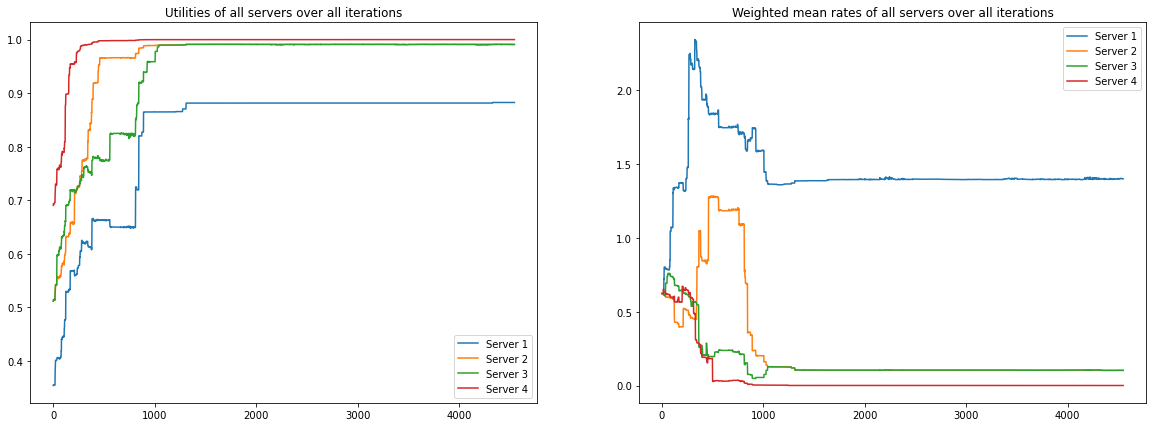

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in utilities_1])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, num_of_servers + 1):
    server_mean_weighted_rates = []
    for itr in range(len(reconstructed_rates_1)):
        current_iteration_mean_weighted_rate = 0
        for state, rate in reconstructed_rates_1[itr][srv].items():
            current_state_prob = reconstructed_state_probs_1[itr][state]
            if not np.isnan(current_state_prob) and state != (0, 0):
                current_iteration_mean_weighted_rate += (
                    reconstructed_rates_1[itr][srv][state] * current_state_prob
                )
        server_mean_weighted_rates.append(current_iteration_mean_weighted_rate)
    ax2.plot(server_mean_weighted_rates)
ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Weighted mean rates of all servers over all iterations")

## Modularisation

In [140]:
def get_plots(utilities, all_rates, all_state_probs, num_of_servers):
    """
    Plot the utilities and the weighte mean rates of all servers over all
    iterations.

    Weighted rate = Rate at state (u,v) * Probability of state (u,v)
    """
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    for srv in range(num_of_servers):
        ax1.plot([util[srv] for util in utilities])

    for srv in range(1, num_of_servers + 1):
        server_mean_weighted_rates = []
        for itr, _ in enumerate(all_rates):
            current_iteration_mean_weighted_rate = 0
            for state, current_rate in all_rates[itr][srv].items():
                current_state_prob = all_state_probs[itr][state]
                if not np.isnan(current_state_prob) and state != (0, 0):
                    current_iteration_mean_weighted_rate += (
                        current_rate * current_state_prob
                    )
            server_mean_weighted_rates.append(current_iteration_mean_weighted_rate)
        ax2.plot(server_mean_weighted_rates)
        
    ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
    ax1.set_title("Utilities of all servers over all iterations")
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
    ax2.set_title("Weighted mean rates of all servers over all iterations")


In [141]:
def get_utilities_rates_and_state_probs(
    filepath, threshold, system_capacity, buffer_capacity
):
    """
    Construct the utilities, rates and state probabilities from file.
    """
    utilities = read_utilities_from_file(filepath + "/utilities.csv")
    raw_rates = read_rates_from_file(filepath + "/rates.csv")
    raw_state_probs = read_states_from_file(filepath + "/state_probs.csv")
    reconstructed_rates = reconstruct_rates(
        raw_rates,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity,
        threshold=threshold,
    )
    reconstructed_state_probs = reconstruct_state_probabilities(
        states_from_file=raw_state_probs, 
        system_capacity=system_capacity, 
        buffer_capacity=buffer_capacity
    )
    return utilities, reconstructed_rates, reconstructed_state_probs 

In [142]:
def plot_utilities_and_weighted_rates(
    filepath, num_of_servers, threshold, system_capacity, buffer_capacity
):
    """
    Calculate the utilities, rates and state probabilities from file and plot
    them.
    """
    utils, rates, state_probs = get_utilities_rates_and_state_probs(
        filepath=filepath,
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity
    )
    get_plots(
        utilities=utils, 
        all_rates=rates, 
        all_state_probs=state_probs,
        num_of_servers=num_of_servers,
    )

In [143]:
lambda_2 = 1
lambda_1 = 0.5
mu = 0.7
num_of_servers = 4
threshold = 7
system_capacity = 10
buffer_capacity = 7

parameters = {
    "lambda_1": lambda_1,
    "lambda_2": lambda_2,
    "mu": mu,
    "num_of_servers": num_of_servers,
    "threshold": threshold,
    "system_capacity": system_capacity,
    "buffer_capacity": buffer_capacity,
}
filepath = get_filepath(parameters)

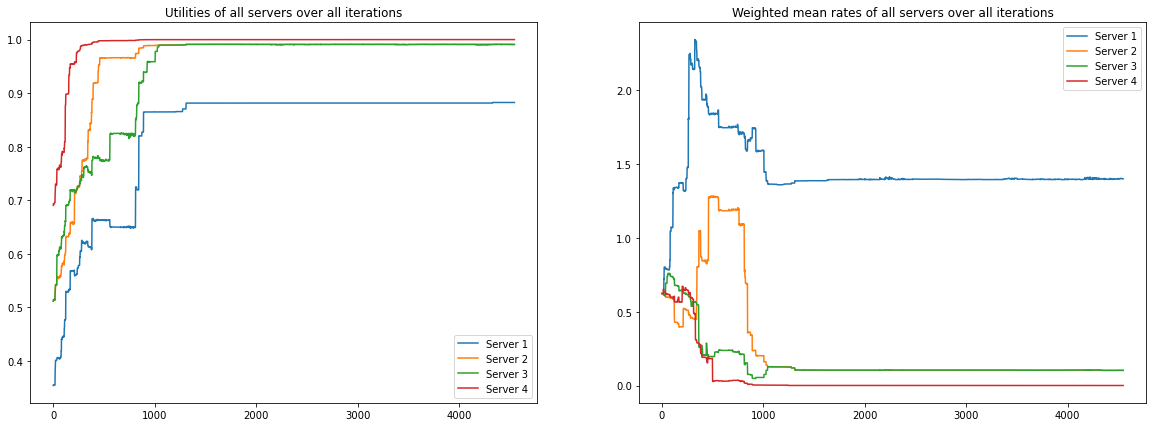

In [144]:
plot_utilities_and_weighted_rates(
    filepath=filepath, 
    num_of_servers=num_of_servers,
    threshold=threshold, 
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity
)